In [ ]:
!pip install matplotlib-venn
!pip install tweepy==4.9.0
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [3]:
#Authentication
from tweepy.auth import OAuthHandler
auth = OAuthHandler("vrXfWLAq7N68NLRpGlIbyxI88", "E6vdhoM8YdcaVlB7Q0pF8rDcpaSazJqun1Lhy16HiE1nkg4PbH")
auth.set_access_token("70369388-9Z3sdeSFEnxCSiXkrjpgfcPSF00nYYNTZlCm1nuEj", "gSINiTLf05Atq5HxtLItWaOaWRFkSJs0f0cd6C3VOCYbh")
api = tweepy.API(auth)

In [ ]:
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAA8KjAEAAAAAkUzjbnIGogMxnSmycCJm6%2B5umlc%3DA3GPqJY9o6SZb0EZoYUnYQbz7YR8leO6vVAaLbxbvqYeUYlMKD')
query = '#elon -is:retweet lang:en'
paginator = tweepy.Paginator(
    client.search_recent_tweets,           # The method you want to use
    query=query,                           # Some argument for this method
    max_results=100,                       # How many tweets per page
    limit=10                               # How many pages to retrieve
)
# Get tweets that contain the hashtag #TypeKeywordHere
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english

tweet_list = []

for tweet in paginator.flatten(): # Total number of tweets to retrieve
    tweet_list.append(tweet)
    #print(tweet)

In [6]:
def preprocess_tweet(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ", sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence

In [7]:
#Creating new dataframe and new features
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,@TheyCallMeDSP cry harder beggar lmfao #ScamAl...
1,@cb_doge @elonmusk Can’t watch tv anymore. It’...
2,#BITCOIN PET ROCK PONZI\n\n#Binance 🔥💣\n\...
3,#NFT collection Elon Musk Life Style \n@anekdo...
4,I hate that people can delete tweets.\nTwitter...


In [8]:
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [10]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,@TheyCallMeDSP cry harder beggar lmfao #ScamAl...,cry harder beggar lmfao scamalert cuck reddit...
1,@cb_doge @elonmusk Can’t watch tv anymore. It’...,doge can watch tv anymore it all elon
2,#BITCOIN PET ROCK PONZI\n\n#Binance 🔥💣\n\...,bitcoin pet rock ponzi binance 30 correction ...
3,#NFT collection Elon Musk Life Style \n@anekdo...,nft collection elon musk life style prirol op...
4,I hate that people can delete tweets.\nTwitter...,i hate that people can delete tweets twitter s...


In [11]:
tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,@TheyCallMeDSP cry harder beggar lmfao #ScamAl...,cry harder beggar lmfao scamalert cuck reddit...,-0.10,0.00,positive,0.131,0.720,0.148,0.1027
1,@cb_doge @elonmusk Can’t watch tv anymore. It’...,doge can watch tv anymore it all elon,0.00,0.00,neutral,0.000,1.000,0.000,0.0000
2,#BITCOIN PET ROCK PONZI\n\n#Binance 🔥💣\n\...,bitcoin pet rock ponzi binance 30 correction ...,0.15,0.75,negative,0.077,0.857,0.066,-0.1027
3,#NFT collection Elon Musk Life Style \n@anekdo...,nft collection elon musk life style prirol op...,0.00,0.00,negative,0.116,0.884,0.000,-0.2732
4,I hate that people can delete tweets.\nTwitter...,i hate that people can delete tweets twitter s...,-0.80,0.90,negative,0.156,0.844,0.000,-0.5719


In [12]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

In [13]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [14]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,589,59.02
neutral,223,22.34
negative,186,18.64


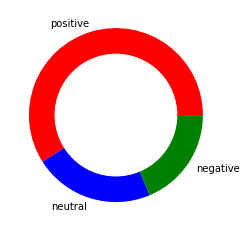

In [15]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")
# names= pc.index
# size=pc["Percentage"]

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['red','blue','green'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [16]:
def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  max_words=100,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("c1_wordcloud.png")
    print("Word Cloud Saved Successfully")
    path="c1_wordcloud.png"
    display(Image.open(path))

Word Cloud Saved Successfully


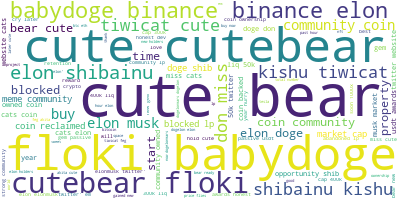

In [21]:
# Creating wordcloud for all tweets

#create_wordcloud(tweet_list_df["cleaned"].values)
create_wordcloud(tweet_list_df_positive["cleaned"].values)
# create_wordcloud(tweet_list_df_negative["cleaned"].values)
# create_wordcloud(tweet_list_df_neutral["cleaned"].values)

In [22]:
tweet_list_df['text_len'] = tweet_list_df['cleaned'].astype(str).apply(len)
tweet_list_df['text_word_count'] = tweet_list_df['cleaned'].apply(lambda x: len(str(x).split()))

In [23]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_len.mean()),2)


,text_len
sentiment,
negative,157.11
neutral,120.97
positive,163.01


In [24]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,25.10
neutral,19.43
positive,27.94


In [25]:
tweet_list_df.to_csv("./sentimentanalysis_output.csv", sep=',', encoding='UTF-8')
tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count
0,@TheyCallMeDSP cry harder beggar lmfao #ScamAl...,cry harder beggar lmfao scamalert cuck reddit...,-0.10,0.00,positive,0.131,0.720,0.148,0.1027,163,19
1,@cb_doge @elonmusk Can’t watch tv anymore. It’...,doge can watch tv anymore it all elon,0.00,0.00,neutral,0.000,1.000,0.000,0.0000,38,8
2,#BITCOIN PET ROCK PONZI\n\n#Binance 🔥💣\n\...,bitcoin pet rock ponzi binance 30 correction ...,0.15,0.75,negative,0.077,0.857,0.066,-0.1027,201,32
3,#NFT collection Elon Musk Life Style \n@anekdo...,nft collection elon musk life style prirol op...,0.00,0.00,negative,0.116,0.884,0.000,-0.2732,122,17
4,I hate that people can delete tweets.\nTwitter...,i hate that people can delete tweets twitter s...,-0.80,0.90,negative,0.156,0.844,0.000,-0.5719,119,22
